# wPCC MDL SLIC model with thrust and wind forces

In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, ModelSimulatorWithPropeller, get_coefficients
from vessel_manoeuvring_models.models.propeller import *
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from copy import deepcopy
from vessel_manoeuvring_models.models.wind_force_helpers import eq_abs, eq_sign
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [5]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [6]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.test_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
wind_data = catalog.load(f"{ship}.wind_data")
model_loaders = catalog.load(f"{ship}.models")
MDL_model_loader = catalog.load(f"wPCC.models")

[05/30/23 15:30:55] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=557689;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=63457;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/30/23 15:30:56] INFO     Kedro project phd                                                      ]8;id=891130;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=686602;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=208035;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=546545;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=863029;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=852903;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=190827;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=395491;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=440013;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=113826;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=386183;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=926271;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=426327;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=609830;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.wind_data' (CSVDataSet)...                   ]8;id=897612;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=554704;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=433452;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=854778;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=965397;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=299963;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [7]:
model_wPCC_MDL = MDL_model_loader['wpcc.updated.vmm_martins_simple.joined.model']()

## Update with 7m main dimensions

In [8]:
model_7m_MDL = model_wPCC_MDL.copy()
model_7m_MDL.ship_parameters.update(ship_data)
model_7m_MDL = deepcopy(model_7m_MDL)

## Add propeller thrust model

Assuming that $w_p := w_{p0}$ is a good model:

In [9]:
eq_w_p = eq_w_p0.subs(w_p0,w_p)
eq_w_p

Eq(w_p, C0_w_p0 + C1_w_p0*U/sqrt(L*g))

In [10]:
eqs = [eq_T,eq_K_T, eq_J, eq_w_p]
solution = sp.solve(eqs, thrust_propeller, K_T, J, w_p, dict=True)
eq_thrust_propeller = sp.Eq(thrust_propeller,n_prop*solution[0][thrust_propeller])
eq_thrust_propeller

Eq(thrust_propeller, D**2*n_prop*rho*(C0_w_p0**2*L*g*k_2*u**2 + 2*C0_w_p0*C1_w_p0*U*k_2*u**2*sqrt(L*g) - C0_w_p0*D*L*g*k_1*rev*u - 2*C0_w_p0*L*g*k_2*u**2 + C1_w_p0**2*U**2*k_2*u**2 - C1_w_p0*D*U*k_1*rev*u*sqrt(L*g) - 2*C1_w_p0*U*k_2*u**2*sqrt(L*g) + D**2*L*g*k_0*rev**2 + D*L*g*k_1*rev*u + L*g*k_2*u**2)/(L*g))

In [11]:
lambda_thrust = lambdify(eq_thrust_propeller.rhs)

In [12]:
params_thrust = {
    'C0_w_p0': 0.10378571428571445,
     'C1_w_p0': 0.24690520231438584,
     'k_0': 0.576581716472807,
     'k_1': -0.3683675998138215,
     'k_2': -0.07542975438913463
}

In [13]:
parameters = dict(model_7m_MDL.parameters.copy())
parameters.update(params_thrust)
g_=9.81
parameters['g'] = g_

model_with_propeller = ModelSimulatorWithPropeller(simulator=model_7m_MDL, 
                                                   parameters=parameters, 
                                                   ship_parameters=model_7m_MDL.ship_parameters, 
                                                   prime_system=model_7m_MDL.prime_system, 
                                                   lambda_thrust=lambda_thrust)
model_with_propeller.parameters = parameters
model_with_propeller.ship_parameters['n_prop'] = ship_data['n_prop']

## Add wind force model

In [14]:
C_x,C_y,C_n = sp.symbols("C_x,C_y,C_n")

In [15]:
deg_x = 5
C_xs = eq_abs(deg=deg_x, symbol_prefix='C_x')
eq_C_x = sp.Eq(C_x,C_xs)
eq_F_Wx = sp.expand(sp.Eq(F_Wx, rho_A*A_XV*aws**2*C_xs))  # 1/2 is stored in the C_x...

deg_y = 3
C_ys = eq_sign(deg=deg_y, symbol_prefix='C_y', const=False) # 1/2 is stored in the C_y...
eq_C_y = sp.Eq(C_y,C_ys)
eq_F_Wy = sp.expand(sp.Eq(F_Wy, rho_A*A_YV*aws**2*C_ys))

deg_n = 3
C_ns = eq_sign(deg=deg_n, symbol_prefix='C_n', const=False)
eq_C_n = sp.Eq(C_n,C_ns)
eq_M_Wz = sp.expand(sp.Eq(M_Wz, rho_A*A_YV*aws**2*C_ns*L)) # 1/2 is stored in the C_n...

display(eq_C_x)
display(eq_C_y)
display(eq_C_n)

display(eq_F_Wx)
display(eq_F_Wy)
display(eq_M_Wz)

Eq(C_x, C_x0 + C_x1*Abs(awa) + C_x2*awa**2 + C_x3*awa**2*Abs(awa) + C_x4*awa**4 + C_x5*awa**4*Abs(awa))

Eq(C_y, C_y1*awa + C_y2*awa*Abs(awa) + C_y3*awa**3)

Eq(C_n, C_n1*awa + C_n2*awa*Abs(awa) + C_n3*awa**3)

Eq(F_Wx, A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa))

Eq(F_Wy, A_YV*C_y1*awa*aws**2*rho_A + A_YV*C_y2*awa*aws**2*rho_A*Abs(awa) + A_YV*C_y3*awa**3*aws**2*rho_A)

Eq(M_Wz, A_YV*C_n1*L*awa*aws**2*rho_A + A_YV*C_n2*L*awa*aws**2*rho_A*Abs(awa) + A_YV*C_n3*L*awa**3*aws**2*rho_A)

In [16]:
eq_to_matrix_C_x = DiffEqToMatrix(eq_C_x, label=C_x, base_features=[awa])

In [17]:
eq_to_matrix_C_x.eq_beta

Eq(beta, Matrix([
[C_x0],
[C_x1],
[C_x2],
[C_x3],
[C_x4],
[C_x5]]))

In [18]:
eq_to_matrix_C_x.eq_X

Eq(X, Matrix([[1, Abs(awa), awa**2, awa**2*Abs(awa), awa**4, awa**4*Abs(awa)]]))

## Coefficients

In [19]:
wind_data_HMD = pd.read_csv("HMD_PCTC.wind_data.csv", index_col=0)
wind_data_HMD.rename(columns={column:column.lower().replace(' ','') for column in wind_data_HMD.columns}, inplace=True)
wind_data_HMD.index=360-wind_data_HMD.index
wind_data_HMD.index = np.deg2rad(wind_data_HMD.index)
wind_data_HMD.index = np.mod(wind_data_HMD.index + np.pi, 2 * np.pi) - np.pi
wind_data_HMD['awa'] = wind_data_HMD.index
wind_data_HMD.index.name = "awa [rad]"
wind_data_HMD.sort_index(inplace=True)

In [20]:
params_wind = {}
X,y = eq_to_matrix_C_x.calculate_features_and_label(data=wind_data_HMD, y=wind_data_HMD['cx'], simplify_names=False)
model_C_x = sm.OLS(y,X, hasconst=False)
model_C_x_fit = model_C_x.fit()
params_wind.update(model_C_x_fit.params)
model_C_x_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     cx   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                              52.08
Date:                Tue, 30 May 2023   Prob (F-statistic):                    7.81e-15
Time:                        15:30:58   Log-Likelihood:                          15.118
No. Observations:                  37   AIC:                                     -18.24
Df Residuals:                      31   BIC:                                     -8.570
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_x0          -0.5972      0.115     -5.172      0.000      -0.833      -0.362
C_x1          -0.9193      0.822     -1.119      0.272      -2.595       0.756
C_x2           4.0736      1.752      2.325      0.027       0.500       7.647
C_x3          -4.2666      1.470     -2.902      0.007      -7.265      -1.268
C_x4           1.7587      0.527      3.340      0.002       0.685       2.833
C_x5          -0.2453      0.067     -3.638      0.001      -0.383      -0.108
==============================================================================
Omnibus:                        1.469   Durbin-Watson:                   0.515
Prob(Omnibus):                  0.480   Jarque-Bera (JB):                1.260
Skew:                           0.436   Prob(JB):                        0.533
Kurtosis:                       2.762   Cond. No.                     8.39e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
eq_to_matrix_C_y = DiffEqToMatrix(eq_C_y, label=C_y, base_features=[awa])
X,y = eq_to_matrix_C_y.calculate_features_and_label(data=wind_data_HMD, y=wind_data_HMD['cy'], simplify_names=False)
model_C_y = sm.OLS(y,X, hasconst=False)
model_C_y_fit = model_C_y.fit()
params_wind.update(model_C_y_fit.params)
model_C_y_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     cy   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                              1591.
Date:                Tue, 30 May 2023   Prob (F-statistic):                    1.31e-36
Time:                        15:30:58   Log-Likelihood:                          46.821
No. Observations:                  37   AIC:                                     -87.64
Df Residuals:                      34   BIC:                                     -82.81
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_y1          -1.5838      0.065    -24.431      0.000      -1.716      -1.452
C_y2           0.5956      0.064      9.364      0.000       0.466       0.725
C_y3          -0.0279      0.015     -1.869      0.070      -0.058       0.002
==============================================================================
Omnibus:                        0.566   Durbin-Watson:                   0.502
Prob(Omnibus):                  0.754   Jarque-Bera (JB):                0.569
Skew:                           0.267   Prob(JB):                        0.752
Kurtosis:                       2.711   Cond. No.                         97.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
eq_to_matrix_C_n = DiffEqToMatrix(eq_C_n, label=C_n, base_features=[awa])
X,y = eq_to_matrix_C_n.calculate_features_and_label(data=wind_data_HMD, y=wind_data_HMD['cn'], simplify_names=False)
model_C_n = sm.OLS(y,X, hasconst=False)
model_C_n_fit = model_C_n.fit()
params_wind.update(model_C_n_fit.params)
model_C_n_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     cn   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              241.4
Date:                Tue, 30 May 2023   Prob (F-statistic):                    5.56e-23
Time:                        15:30:58   Log-Likelihood:                          100.61
No. Observations:                  37   AIC:                                     -195.2
Df Residuals:                      34   BIC:                                     -190.4
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C_n1          -0.3157      0.015    -20.843      0.000      -0.347      -0.285
C_n2           0.3252      0.015     21.882      0.000       0.295       0.355
C_n3          -0.0722      0.003    -20.724      0.000      -0.079      -0.065
==============================================================================
Omnibus:                        8.044   Durbin-Watson:                   0.606
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                2.647
Skew:                           0.259   Prob(JB):                        0.266
Kurtosis:                       1.797   Cond. No.                         97.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
lambda_C_x = lambdify(eq_C_x.rhs)
lambda_C_y = lambdify(eq_C_y.rhs)
lambda_C_n = lambdify(eq_C_n.rhs)

In [24]:
wind_data_HMD_predict = wind_data_HMD.copy()
wind_data_HMD_predict['cx'] = run(function=lambda_C_x, inputs=wind_data_HMD, **params_wind)
wind_data_HMD_predict['cy'] = run(function=lambda_C_y, inputs=wind_data_HMD, **params_wind)
wind_data_HMD_predict['cn'] = run(function=lambda_C_n, inputs=wind_data_HMD, **params_wind)

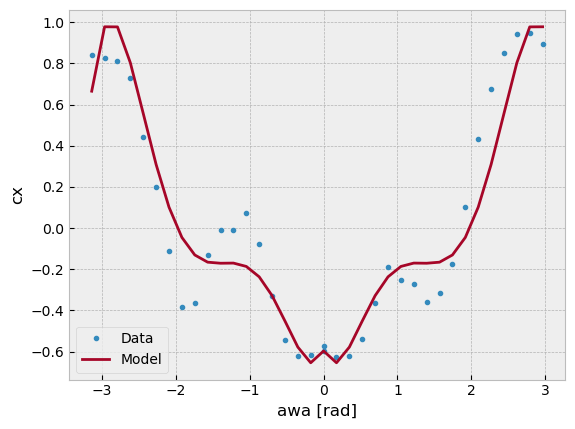

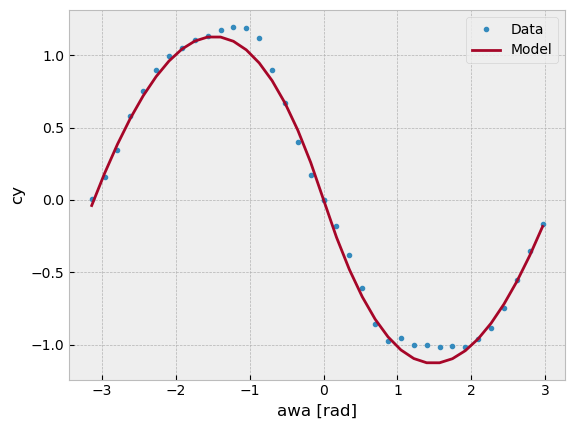

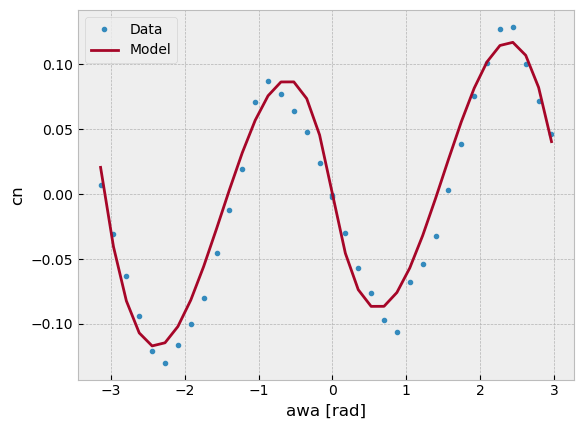

In [25]:
for dof in ['cx','cy','cn']:
    fig,ax=plt.subplots()
    wind_data_HMD.plot(y=dof, ax=ax, style='.', label='Data')
    wind_data_HMD_predict.plot(y=dof, ax=ax, style='-', label='Model')
    ax.set_ylabel(dof)


In [26]:
model_7m_MDL.X_eq

Eq(m*(\dot{u} - r**2*x_G - r*v), X_{\dot{u}}*\dot{u} + X_{deltadelta}*delta**2 + X_{rr}*r**2 + X_{thrust}*thrust + X_{uu}*u**2 + X_{u}*u + X_{vr}*r*v)

In [27]:
X_eq = sp.Eq(model_with_propeller.X_eq.lhs, model_with_propeller.X_eq.rhs + eq_F_Wx.rhs)
Y_eq = sp.Eq(model_with_propeller.Y_eq.lhs, model_with_propeller.Y_eq.rhs + eq_F_Wy.rhs)
N_eq = sp.Eq(model_with_propeller.N_eq.lhs, model_with_propeller.N_eq.rhs + eq_M_Wz.rhs)

In [28]:
simulator = Simulator(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq)
vmm = VMM(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq)
simulator.define_quasi_static_forces(X_qs_eq=vmm.X_qs_eq, Y_qs_eq=vmm.Y_qs_eq, N_qs_eq=vmm.N_qs_eq)

In [29]:
parameters = model_with_propeller.parameters.copy()
parameters.update(params_wind)

In [30]:
model_with_propeller_wind = ModelSimulatorWithPropeller(simulator=simulator, parameters=parameters, ship_parameters=ship_data, control_keys=['delta','twa','tws'], prime_system=model_with_propeller.prime_system, lambda_thrust=lambda_thrust)
model_with_propeller_wind.parameters = parameters

## Save models

In [31]:
model_with_propeller.parameters = pd.Series(model_with_propeller.parameters)
model_with_propeller_wind.parameters = pd.Series(model_with_propeller_wind.parameters)


try:
    model_loaders_7m = catalog.load(f"7m.models")
except Exception:
    model_loaders_7m = {}
    
model_loaders_7m["SLIC_propeller"] = model_with_propeller
model_loaders_7m["SLIC_propeller_wind"] = model_with_propeller_wind

catalog.save(f"7m.models", model_loaders_7m)

[05/30/23 15:31:01] INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=836722;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=646670;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Saving data to '7m.models' (PartitionedDataSet)...                 ]8;id=506681;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=620908;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\